# COMPSCI 109 A: Exploratory Data Analysis for Milestone #3

There are four datasets that we cover in our analysis below:

1. IRS Statistics of Income Tax Migration Data
2. USPS FOIA National Change-of-Address Data
3. US Census Bureau's ACS annual survey
4. School Enrollment and Absenteeism Data

In [1]:
# load necessary libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import warnings

In [2]:
# set directory
os.chdir('/Users/shreyad/Library/CloudStorage/OneDrive-HarvardUniversity/DS Final Project/1. Data')
#print(os.getcwd())

# ignore warnings for a clean file
warnings.filterwarnings('ignore')

### 1. IRS Statistics of Income Tax Migration Data

In [3]:
#We checked inflow data to make sure it matches the outflow data. Our checks showed that the two mirrored each other so we will only use the outflow dataset moving forward but use inflow data for labels that are missing in outflow data
inf_1920 = pd.read_csv("4. IRS Statistics of Income Tax Migration Data/Final Data/countyinflow1920.csv")
inf_2021 = pd.read_csv("4. IRS Statistics of Income Tax Migration Data/Final Data/countyinflow2021.csv")
inf_1920['year1'] = '2019'
inf_1920['year2'] = '2020'
inf_2021['year1'] = '2020'
inf_2021['year2'] = '2021'

#agi (adjusted gross income in year 2)
inflow = pd.concat([inf_1920, inf_2021], ignore_index=True)
inflow = inflow[~inflow['y1_countyname'].str.contains('Count Total|Foreign|Total Migration|Other flows|Non-migrants', case=False, na=False)]
#inflow agi is agi of origin county
inflow.rename(columns={'agi': 'agi_orig'}, inplace=True)
# Drop 'n1' column from 'inflow' DataFrame - we'll only look at # of individuals moving
inflow.drop(columns=['n1'], inplace=True)
inflow.rename(columns={'n2': 'n2_inflows'}, inplace=True)
#inflow = inflow[(inflow['y1_state'] == 'NY') | (inflow['y2_statefips'] == 36)]

In [4]:
#Read CSVs
outf_1920 = pd.read_csv("4. IRS Statistics of Income Tax Migration Data/Final Data/countyoutflow1920.csv")
outf_2021 = pd.read_csv("4. IRS Statistics of Income Tax Migration Data/Final Data/countyoutflow2021.csv")
#Add year columns before merging
outf_1920['year1'] = '2019'
outf_1920['year2'] = '2020'
outf_2021['year1'] = '2020'
outf_2021['year2'] = '2021'
# Concatenate the two years of data
outflow = pd.concat([outf_1920, outf_2021], ignore_index=True)

In [5]:
#We clean up the dataset by removing the sums, other flows, non-migrant reports and also the foreign travel (which is small but clutters the rows)
# The inflow file shows migration flows into the destination state and county in year one from the origin state and county in year two. 
outflow = outflow[~outflow['y2_countyname'].str.contains('Count Total|Foreign|Total Migration|Other flows|Non-migrants', case=False, na=False)]

# Drop 'n1' column from 'outflow' DataFrame - we'll only look at # of individuals moving
outflow.drop(columns=['n1'], inplace=True)

# Rename 'agi' column in 'outflow' DataFrame to 'agi_year2' and 'n2' is number of individuals in the year2 tax return
outflow.rename(columns={'agi': 'agi_year2'}, inplace=True)
outflow.rename(columns={'n2': 'n_ind_year2'}, inplace=True)

In [6]:
#We only want to see people who moved into NY state from any other place or people who left NY state to go any other place in the US (NY FIPS Code is 36). So we get flows into and out of NY 
flows = outflow[(outflow['y2_state'] == 'NY') | (outflow['y1_statefips'] == 36)]

In [7]:
#Add names of origin county and origin state (not in outflow data)
inflow['y1_key'] = inflow['y1_statefips'].astype(str) + '-' + inflow['y1_countyfips'].astype(str)
flows['y1_key'] = flows['y1_statefips'].astype(str) + '-' + flows['y1_countyfips'].astype(str)

crosswalk_county = inflow[['y1_key', 'y1_countyname']].drop_duplicates()
crosswalk_county_unique = pd.Series(crosswalk_county['y1_countyname'].values, index=crosswalk_county['y1_key']).to_dict()

unique_states = inflow.drop_duplicates(subset='y1_statefips')[['y1_statefips','y1_state']]
crosswalk_state = pd.Series(unique_states['y1_state'].values, index=unique_states['y1_statefips']).drop_duplicates()

# Insert 'y1_countyname' at the first column position (index 0) directly
flows.insert(0, 'y1_countyname', flows['y1_key'].map(crosswalk_county_unique))
flows.insert(1, 'y1_state', flows['y1_statefips'].map(crosswalk_state))

In [8]:
#Rename columns to make interpretation more intuitive
flows.rename(
    columns={
        'y1_countyname': 'from_county',
        'y1_state': 'from_state',
        'y1_statefips': 'from_statefips',
        'y1_countyfips': 'from_countyfips',
        'y2_countyname': 'to_county',
        'y2_state': 'to_state',
        'y2_statefips': 'to_statefips',
        'y2_countyfips': 'to_countyfips'
    },
    inplace=True
)

In [9]:
#Make sure there are no missings!
missing_values = flows.isnull().sum()
print(missing_values)

from_county        0
from_state         0
from_statefips     0
from_countyfips    0
to_statefips       0
to_countyfips      0
to_state           0
to_county          0
n_ind_year2        0
agi_year2          0
year1              0
year2              0
y1_key             0
dtype: int64


In [10]:
#clean agi var and remove any value <= 0 (there are only a couple of these issues)
flows = flows[flows['agi_year2'] > 0]

In [11]:
inflows = flows[flows['to_state'] == 'NY'].groupby(['to_county','to_state', 'year2']).agg({'n_ind_year2': 'sum','agi_year2': 'mean'}).reset_index()
inflows.rename(columns={'to_county': 'county', 'to_state': 'state','n_ind_year2': 'n_inflows', 'agi_year2': 'agi_incomers', 'year2': 'year'}, inplace=True)

outflows = flows[flows['from_state'] == 'NY'].groupby(['from_county','from_state', 'year2']).agg({'n_ind_year2': 'sum','agi_year2': 'mean'}).reset_index()
outflows.rename(columns={'from_county': 'county', 'from_state': 'state', 'n_ind_year2': 'n_outflows','agi_year2': 'agi_leavers', 'year2': 'year'}, inplace=True)

In [12]:
net_migration = pd.merge(inflows, outflows, on=['county', 'state', 'year'], how='outer')
net_migration['net_flows'] = net_migration['n_inflows'] - net_migration['n_outflows']


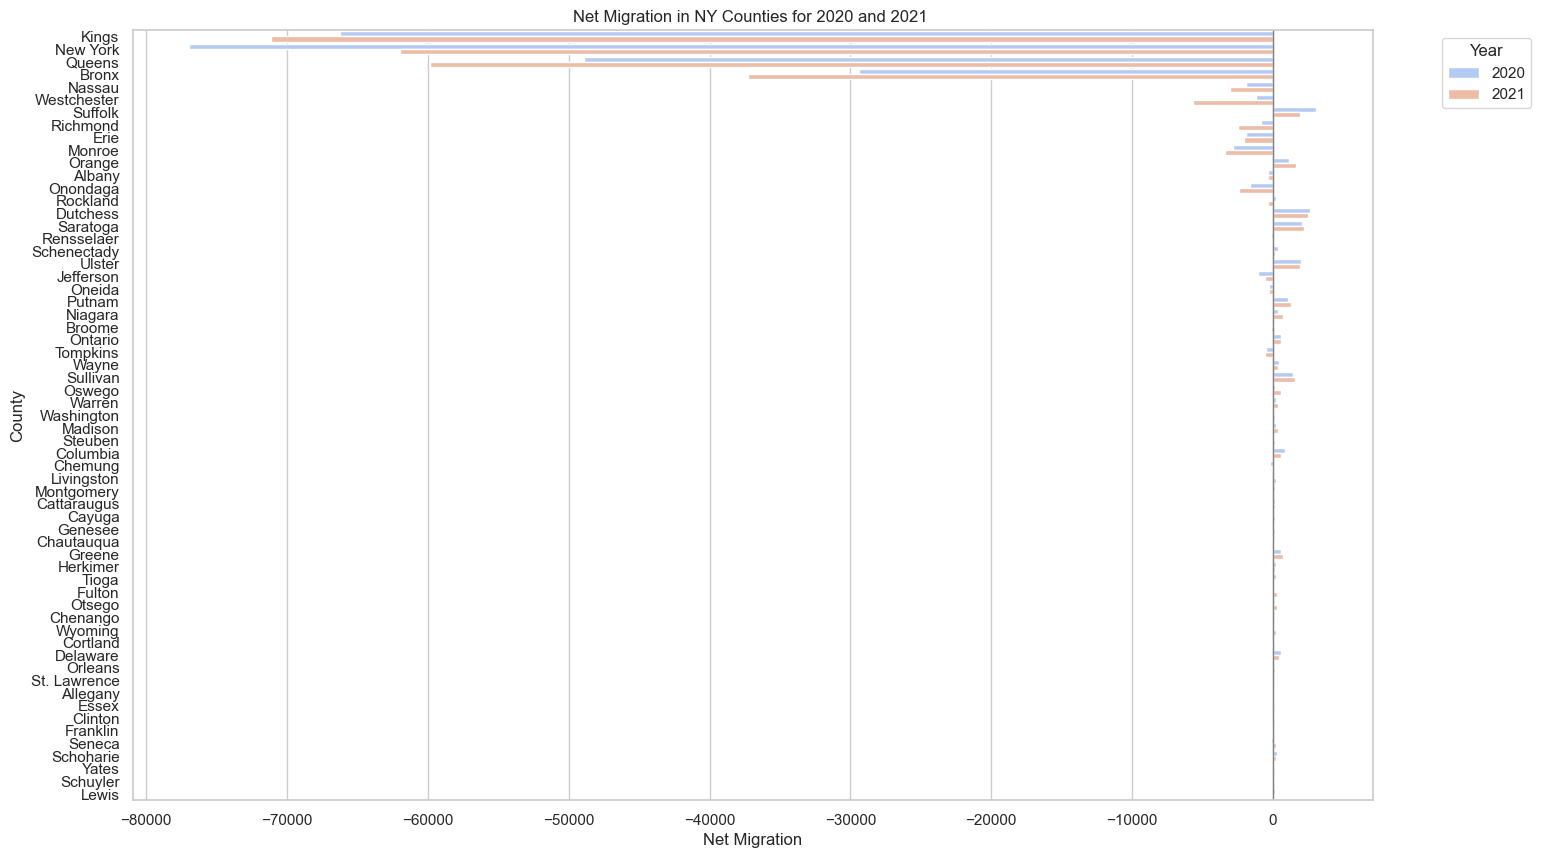

In [13]:
#NEED TO GET POPULATION BY COUNTY SO I CAN DO MIGRATION SHARES!!
#PLOT NET MIGRATION BY COUNTY IN NEW YORK
sns.set_theme(style="whitegrid")

# Ensure 'year' is of type string for proper categorical hue representation
net_migration['year'] = net_migration['year'].astype(str)

# Filter the DataFrame for the years 2020 and 2021 only
net_migration_filtered = net_migration
net_migration_filtered['county'] = net_migration['county'].str.replace(' County', '', regex=False)

# Sort the counties by 2021 outmigration
outflows_2021 = net_migration_filtered[(net_migration_filtered['year'] == '2021')].set_index('county')['n_outflows']
net_migration_filtered = net_migration_filtered.join(outflows_2021, on='county', rsuffix='_2021_outflow')

# Now sort by the outflow of 2021 and then drop the helper column
net_migration_filtered.sort_values(by='n_outflows_2021_outflow', ascending=False, inplace=True)
net_migration_filtered.drop(columns=['n_outflows_2021_outflow'], inplace=True)

# Create a bar plot with hue for different years
plt.figure(figsize=(16, 10))
barplot = sns.barplot(
    x='net_flows',
    y='county',
    hue='year',
    data=net_migration_filtered,
    palette='coolwarm',
    errorbar=None
)

# Add a line at zero for net migration reference
plt.axvline(0, color='grey', linewidth=1)

# Move the legend to the outside of the plot, on the right
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve the aesthetics
plt.xlabel('Net Migration') 
plt.ylabel('County') 
plt.title('Net Migration in NY Counties for 2020 and 2021 ') 

# Show the plot
plt.show()

In [14]:
inflows['log_agi_incomers'] = np.log(inflows['agi_incomers'])
outflows['log_agi_leavers'] = np.log(outflows['agi_leavers'])

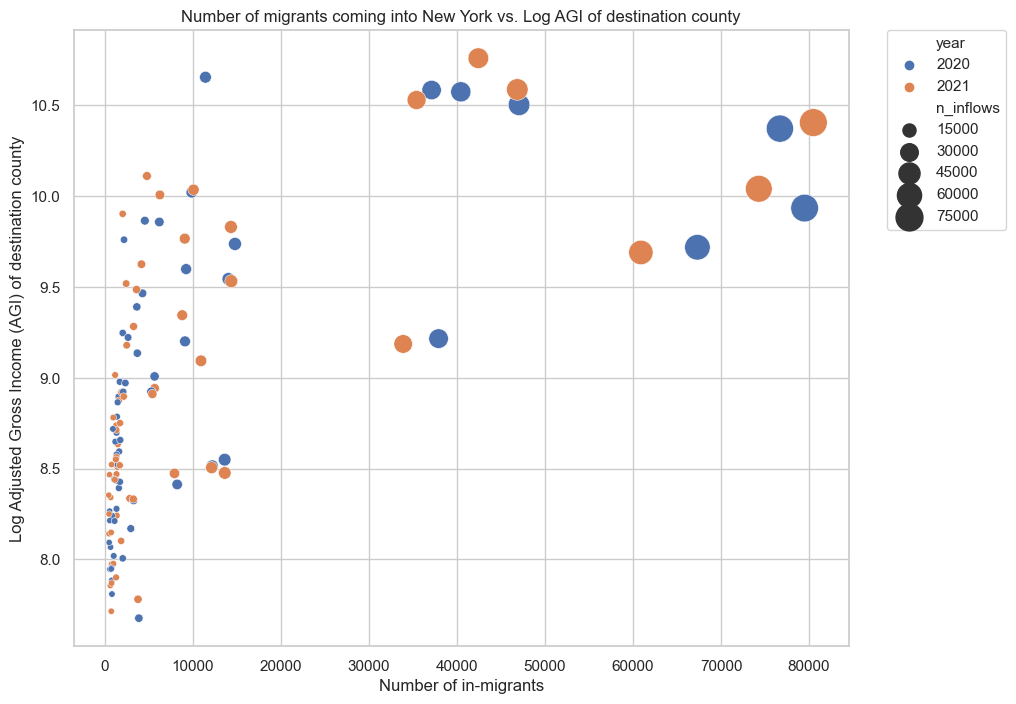

In [15]:
#Migration into the state by county and the AGI of that county 
plt.figure(figsize=(10, 8))
sns.scatterplot(data=inflows, x='n_inflows', y='log_agi_incomers', hue='year',size='n_inflows', sizes=(20, 400))
plt.title('Number of migrants coming into New York vs. Log AGI of destination county')
plt.ylabel('Log Adjusted Gross Income (AGI) of destination county')
plt.xlabel('Number of in-migrants')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

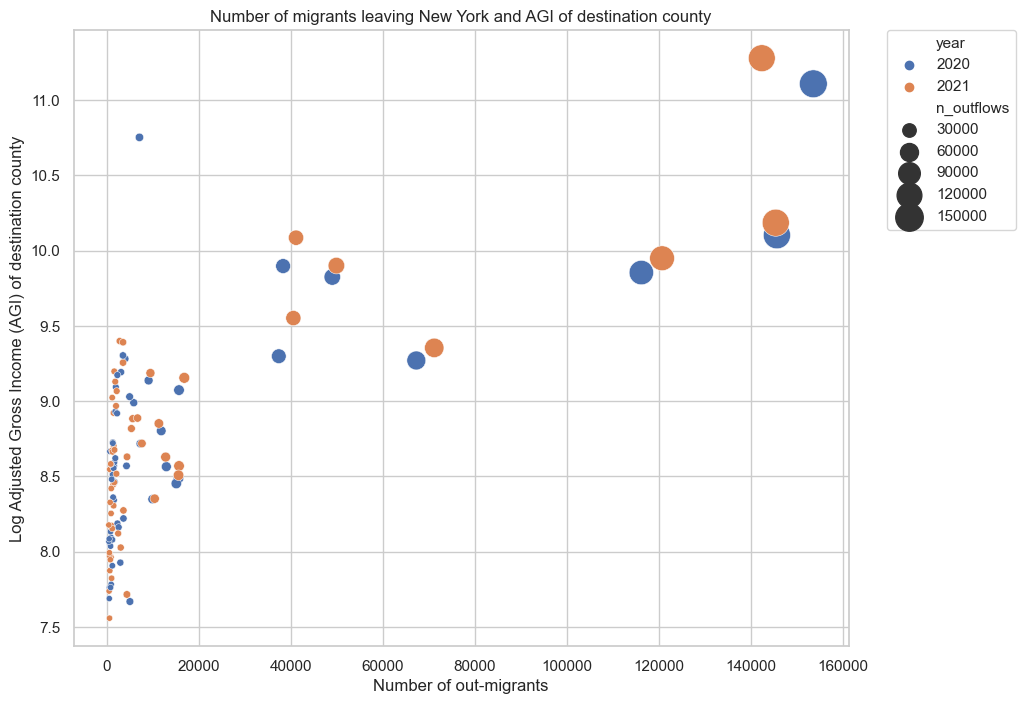

In [16]:
#Migration out of the state by county and the AGI of that county 
plt.figure(figsize=(10, 8))
sns.scatterplot(data=outflows, x='n_outflows', y='log_agi_leavers', hue='year',size='n_outflows', sizes=(20, 400))
plt.title('Number of migrants leaving New York and AGI of destination county')
plt.ylabel('Log Adjusted Gross Income (AGI) of destination county')
plt.xlabel('Number of out-migrants')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

In [17]:
#We can merge the net_migration table to other county level data (e.g. school enrollment/county demographicsdd)
net_migration

county state  year  n_inflows  agi_incomers  n_outflows  \
0         Albany    NY  2020      11450  42426.520000       11798   
1         Albany    NY  2021      10942   8901.510204       11282   
2       Allegany    NY  2020        817   2657.857143         754   
3       Allegany    NY  2021        795   2906.714286         711   
4          Bronx    NY  2020      37924  10059.186047       67282   
..           ...   ...   ...        ...           ...         ...   
117  Westchester    NY  2021      35424  37421.226190       41117   
118      Wyoming    NY  2020       1075   4636.666667        1019   
119      Wyoming    NY  2021       1162   4623.428571         925   
120        Yates    NY  2020        569   3891.400000         480   
121        Yates    NY  2021        500   3830.400000         523   

      agi_leavers  net_flows  
0     6651.179104       -348  
1     6984.348485       -340  
2     2849.166667         63  
3     2897.500000         84  
4    10612.786585     -29358  
..            ...        ...  
117  23987.169811      -5693  
118   4821.833333         56  
119   4536.166667        237  
120   3246.250000         89  
121   2961.000000        -23  

[122 rows x 8 columns]

### 2. USPS FOIA National Change-of-Address Data

In [18]:
# loading the USPS data
coa_usps_2020 = pd.read_csv("1. Change of Address Stats/Y2020.csv")
coa_usps_2021 = pd.read_csv("1. Change of Address Stats/Y2021.csv")

In [19]:
# load the ZIP to County crosswalk

zip_county_crosswalk = pd.read_csv("/Users/shreyad/Library/CloudStorage/OneDrive-HarvardUniversity/DS Final Project/1. Data/6. Crosswalks/zip_county_122022.csv")

In [20]:
# cleaning the ZIP Code variable in 2020 dataset
coa_usps_2020['ZIPCODE'] = coa_usps_2020['ZIPCODE'].str.replace('="', '', regex=False)
coa_usps_2020['ZIPCODE'] = coa_usps_2020['ZIPCODE'].str.replace('"', '', regex=False)

# cleaning the ZIP Code variable in 2021 dataset
coa_usps_2021['ZIPCODE'] = coa_usps_2021['ZIPCODE'].str.replace('="', '', regex=False)
coa_usps_2021['ZIPCODE'] = coa_usps_2021['ZIPCODE'].str.replace('"', '', regex=False)

In [21]:
# 2020 dataset review
coa_usps_2020.head()

YYYYMM ZIPCODE                          CITY STATE  TOTAL FROM ZIP  \
0  202001   00601  ADJUNTAS                        PR              13   
1  202001   00602  AGUADA                          PR              25   
2  202001   00603  AGUADILLA                       PR              45   
3  202001   00605  AGUADILLA                       PR              13   
4  202001   00610  ANASCO                          PR              20   

   TOTAL BUSINESS  TOTAL FAMILY  TOTAL INDIVIDUAL  TOTAL PERM  TOTAL TEMP  \
0               0             0                 0          13           0   
1               0             0                16          25           0   
2               0            15                27          40           0   
3               0             0                 0          12           0   
4               0             0                20          19           0   

   TOTAL TO ZIP  TOTAL BUSINESS.1  TOTAL FAMILY.1  TOTAL INDIVIDUAL.1  \
0             0                 0               0                   0   
1            40                 0               0                  27   
2            63                 0              15                  45   
3            18                 0               0                  12   
4            21                 0               0                  18   

   TOTAL PERM.1  TOTAL TEMP.1  
0             0             0  
1            34             0  
2            49            14  
3            17             0  
4            17             0

In [22]:
coa_usps_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289338 entries, 0 to 289337
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   YYYYMM              289338 non-null  int64 
 1   ZIPCODE             289338 non-null  object
 2   CITY                289338 non-null  object
 3   STATE               289338 non-null  object
 4   TOTAL FROM ZIP      289338 non-null  int64 
 5   TOTAL BUSINESS      289338 non-null  int64 
 6   TOTAL FAMILY        289338 non-null  int64 
 7   TOTAL INDIVIDUAL    289338 non-null  int64 
 8   TOTAL PERM          289338 non-null  int64 
 9   TOTAL TEMP          289338 non-null  int64 
 10  TOTAL TO ZIP        289338 non-null  int64 
 11  TOTAL BUSINESS.1    289338 non-null  int64 
 12  TOTAL FAMILY.1      289338 non-null  int64 
 13  TOTAL INDIVIDUAL.1  289338 non-null  int64 
 14  TOTAL PERM.1        289338 non-null  int64 
 15  TOTAL TEMP.1        289338 non-null  int64 
dtypes:

In [23]:
# 2021 dataset review
coa_usps_2021.head()

YYYYMM ZIPCODE                          CITY STATE  TOTAL FROM ZIP  \
0  202101   00601  ADJUNTAS                        PR              15   
1  202101   00602  AGUADA                          PR              30   
2  202101   00603  AGUADILLA                       PR              43   
3  202101   00605  AGUADILLA                       PR              12   
4  202101   00610  ANASCO                          PR              25   

   TOTAL BUSINESS  TOTAL FAMILY  TOTAL INDIVIDUAL  TOTAL PERM  TOTAL TEMP  \
0               0             0                 0          13           0   
1               0             0                21          29           0   
2               0             0                35          39           0   
3               0             0                 0           0           0   
4               0             0                16          22           0   

   TOTAL TO ZIP  TOTAL BUSINESS.1  TOTAL FAMILY.1  TOTAL INDIVIDUAL.1  \
0            17                 0               0                   0   
1            48                 0               0                  41   
2            42                 0              13                  28   
3            22                 0              12                   0   
4            30                 0              13                  17   

   TOTAL PERM.1  TOTAL TEMP.1  
0            15             0  
1            43             0  
2            35             0  
3            20             0  
4            21             0

In [24]:
coa_usps_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284873 entries, 0 to 284872
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   YYYYMM              284873 non-null  int64 
 1   ZIPCODE             284873 non-null  object
 2   CITY                284873 non-null  object
 3   STATE               284873 non-null  object
 4   TOTAL FROM ZIP      284873 non-null  int64 
 5   TOTAL BUSINESS      284873 non-null  int64 
 6   TOTAL FAMILY        284873 non-null  int64 
 7   TOTAL INDIVIDUAL    284873 non-null  int64 
 8   TOTAL PERM          284873 non-null  int64 
 9   TOTAL TEMP          284873 non-null  int64 
 10  TOTAL TO ZIP        284873 non-null  int64 
 11  TOTAL BUSINESS.1    284873 non-null  int64 
 12  TOTAL FAMILY.1      284873 non-null  int64 
 13  TOTAL INDIVIDUAL.1  284873 non-null  int64 
 14  TOTAL PERM.1        284873 non-null  int64 
 15  TOTAL TEMP.1        284873 non-null  int64 
dtypes:

In [25]:
# keep only relevant variables
keep_columns = ['YYYYMM', 'ZIPCODE', 'CITY', 'STATE', 'TOTAL FROM ZIP', 'TOTAL TO ZIP'] 
coa_data_2020_analysis = coa_usps_2020[keep_columns]
coa_data_2021_analysis = coa_usps_2021[keep_columns]

# add year variables
coa_data_2020_analysis.loc[:, 'Year'] = '2020'
coa_data_2021_analysis.loc[:, 'Year'] = '2021'

In [26]:
# append the two datasets 
coa_data_combined = pd.concat([coa_data_2020_analysis, coa_data_2021_analysis], ignore_index=True)

# cleaning column names in the final dataset
coa_data_combined = coa_data_combined.rename(columns={'TOTAL FROM ZIP': 'outflow'})
coa_data_combined = coa_data_combined.rename(columns={'TOTAL TO ZIP': 'inflow'})

# keeping all columns as lower case
coa_data_combined.columns = [col.lower() for col in coa_data_combined.columns]

In [27]:
coa_data_combined.head()

yyyymm zipcode                          city state  outflow  inflow  year
0  202001   00601  ADJUNTAS                        PR       13       0  2020
1  202001   00602  AGUADA                          PR       25      40  2020
2  202001   00603  AGUADILLA                       PR       45      63  2020
3  202001   00605  AGUADILLA                       PR       13      18  2020
4  202001   00610  ANASCO                          PR       20      21  2020

In [28]:
zip_county_crosswalk.head()
zip_county_crosswalk = zip_county_crosswalk.rename(columns={'ZIP': 'zipcode'})
zip_county_crosswalk.columns = [col.lower() for col in zip_county_crosswalk.columns]
zip_county_crosswalk['zipcode'] = zip_county_crosswalk['zipcode'].astype(str)

In [29]:
# select specific variables to keep for the merge
zip_county_crosswalk_merge = zip_county_crosswalk[['zipcode', 'county', 'usps_zip_pref_city']]

In [30]:
coa_data_combined_county = pd.merge(coa_data_combined, zip_county_crosswalk_merge, on='zipcode', how='inner')

In [31]:
coa_data_combined_county.head()

yyyymm zipcode                          city state  outflow  inflow  year  \
0  202001   10001  NEW YORK                        NY      476     474  2020   
1  202002   10001  NEW YORK                        NY      407     485  2020   
2  202003   10001  NEW YORK                        NY     1547     449  2020   
3  202004   10001  NEW YORK                        NY      990     288  2020   
4  202005   10001  NEW YORK                        NY      982     338  2020   

   county usps_zip_pref_city  
0   36061           NEW YORK  
1   36061           NEW YORK  
2   36061           NEW YORK  
3   36061           NEW YORK  
4   36061           NEW YORK

In [32]:
coa_county_level_data = coa_data_combined_county.groupby(['county', 'year']).agg({
    'inflow': 'sum',
    'outflow': 'sum',
    'city': 'first'  # Assuming 'city' is your city variable
}).reset_index()

coa_county_level_data.head()

county  year  inflow  outflow                          city
0    1001  2020    7503     7621  AUTAUGAVILLE                
1    1001  2021    7057     7358  AUTAUGAVILLE                
2    1003  2020   34053    28959  URIAH                       
3    1003  2021   33456    28686  URIAH                       
4    1005  2020    1918     1986  CLAYTON

In [33]:
# Filter data for 2020 and 2021
data_2020 = coa_county_level_data[coa_county_level_data['year'] == '2020']
data_2021 = coa_county_level_data[coa_county_level_data['year'] == '2021']

# Identifying top 5 counties for inflow and outflow
# Top 5 counties for 2020
top_5_inflow_2020 = data_2020.nlargest(5, 'inflow')
top_5_outflow_2020 = data_2020.nlargest(5, 'outflow')

# Top 5 counties for 2021
top_5_inflow_2021 = data_2021.nlargest(5, 'inflow')
top_5_outflow_2021 = data_2021.nlargest(5, 'outflow')

In [34]:
top_5_inflow_2020['city'] = top_5_inflow_2020['city'].str.strip()
top_5_outflow_2020['city'] = top_5_outflow_2020['city'].str.strip()

top_5_outflow_2021['city'] = top_5_outflow_2021['city'].str.strip()
top_5_inflow_2021['city'] = top_5_inflow_2021['city'].str.strip()

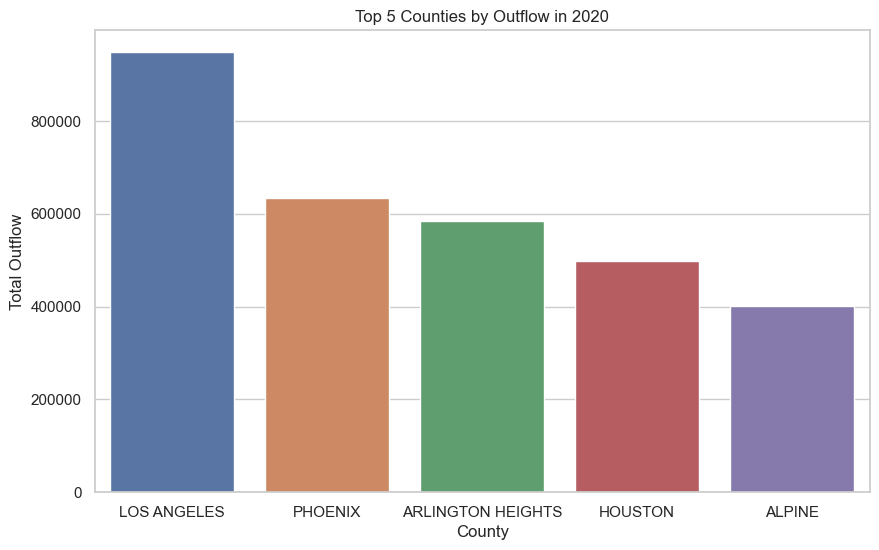

In [35]:
# Outflow plot for 2020
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=top_5_outflow_2020, x='city', y='outflow')
plt.title('Top 5 Counties by Outflow in 2020')
plt.xlabel('County')
plt.ylabel('Total Outflow')
plt.show()

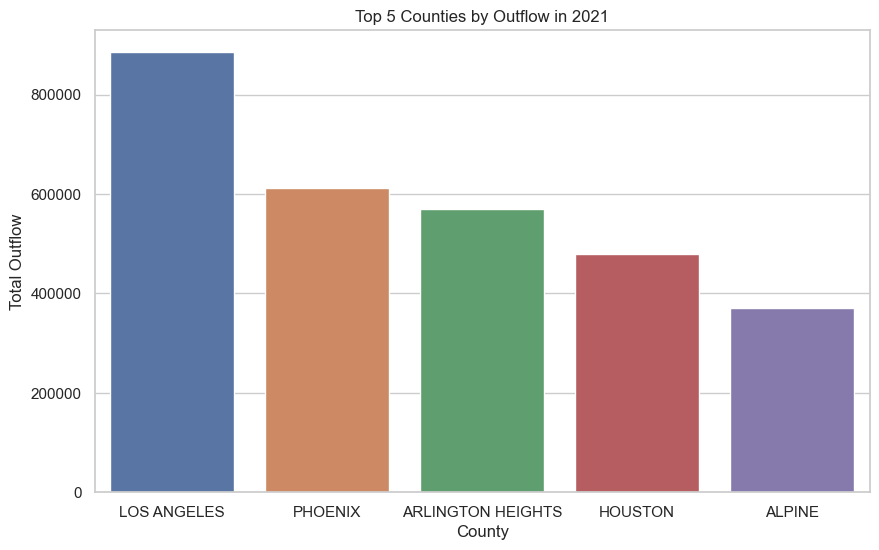

In [36]:
# Outflow plot for 2021
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=top_5_outflow_2021, x='city', y='outflow')
plt.title('Top 5 Counties by Outflow in 2021')
plt.xlabel('County')
plt.ylabel('Total Outflow')
plt.show()

### 3. US Census Bureau's ACS annual survey

In [60]:
filtered_ACS = pd.read_csv('3. US Census/filtered_ACS.csv')

In [61]:
filtered_ACS.head()

GEO_ID                NAME_2019                NAME_2021  \
0       Geography     Geographic Area Name     Geographic Area Name   
1  0500000US01003  Baldwin County, Alabama  Baldwin County, Alabama   
2  0500000US01015  Calhoun County, Alabama  Calhoun County, Alabama   
3  0500000US01043  Cullman County, Alabama  Cullman County, Alabama   
4  0500000US01049   DeKalb County, Alabama   DeKalb County, Alabama   

                 NAME_2022                          DP05_0001E_2019  \
0     Geographic Area Name  Estimate!!SEX AND AGE!!Total population   
1  Baldwin County, Alabama                                   223234   
2  Calhoun County, Alabama                                   113605   
3  Cullman County, Alabama                                    83768   
4   DeKalb County, Alabama                                    71513   

                                 DP05_0002E_2019  \
0  Estimate!!SEX AND AGE!!Total population!!Male   
1                                         109192   
2                                          54285   
3                                          40579   
4                                          35688   

                                   DP05_0003E_2019  \
0  Estimate!!SEX AND AGE!!Total population!!Female   
1                                           114042   
2                                            59320   
3                                            43189   
4                                            35825   

                                     DP05_0004E_2019  \
0  Estimate!!SEX AND AGE!!Total population!!Sex r...   
1                                               95.7   
2                                               91.5   
3                                               94.0   
4                                               99.6   

                                     DP05_0005E_2019  \
0  Estimate!!SEX AND AGE!!Total population!!Under...   
1                                              10616   
2                                               6699   
3                                               5310   
4                                               4578   

                                     DP05_0006E_2019  ...  \
0  Estimate!!SEX AND AGE!!Total population!!5 to ...  ...   
1                                              12826  ...   
2                                               5534  ...   
3                                               4563  ...   
4                                               4292  ...   

                                     DP05_0086E_2022  \
0  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...   
1                                               1825   
2                                                330   
3                                                897   
4                                                453   

                                     DP05_0087E_2022  \
0  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...   
1                                               9670   
2                                               2334   
3                                               1872   
4                                               2053   

                 DP05_0088E_2022  \
0  Estimate!!Total housing units   
1                         132299   
2                          53408   
3                          39893   
4                          31022   

                                     DP05_0089E_2022  \
0  Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...   
1                                             189876   
2                                              90642   
3                                              69096   
4                                              52110   

                                     DP05_0090E_2022  \
0  Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...   
1                                              91296   
2                                              43301   
3                         

In [62]:
# drop the first row of the dataset
filtered_ACS_analysis = filtered_ACS.iloc[1:]

# update the geographic name for the data

filtered_ACS_analysis['NAME_2022'] = filtered_ACS_analysis['NAME_2022'].str.split(',').str[0]
filtered_ACS_analysis['NAME_2022'] = filtered_ACS_analysis['NAME_2022'].str.lower()
filtered_ACS_analysis['NAME_2022'] = filtered_ACS_analysis['NAME_2022'].str.replace(' county', '')
filtered_ACS_analysis.rename(columns={'NAME_2022': 'county_22'}, inplace=True)

filtered_ACS_analysis['NAME_2021'] = filtered_ACS_analysis['NAME_2021'].str.split(',').str[0]
filtered_ACS_analysis['NAME_2021'] = filtered_ACS_analysis['NAME_2021'].str.lower()
filtered_ACS_analysis['NAME_2021'] = filtered_ACS_analysis['NAME_2021'].str.replace(' county', '')
filtered_ACS_analysis.rename(columns={'NAME_2021': 'county'}, inplace=True)

In [63]:
filtered_ACS_analysis.head()

GEO_ID                NAME_2019   county county_22 DP05_0001E_2019  \
1  0500000US01003  Baldwin County, Alabama  baldwin   baldwin          223234   
2  0500000US01015  Calhoun County, Alabama  calhoun   calhoun          113605   
3  0500000US01043  Cullman County, Alabama  cullman   cullman           83768   
4  0500000US01049   DeKalb County, Alabama   dekalb    dekalb           71513   
5  0500000US01051   Elmore County, Alabama   elmore    elmore           81209   

  DP05_0002E_2019 DP05_0003E_2019 DP05_0004E_2019 DP05_0005E_2019  \
1          109192          114042            95.7           10616   
2           54285           59320            91.5            6699   
3           40579           43189            94.0            5310   
4           35688           35825            99.6            4578   
5           40060           41149            97.4            4272   

  DP05_0006E_2019  ... DP05_0086E_2022 DP05_0087E_2022 DP05_0088E_2022  \
1           12826  ...            1825            9670          132299   
2            5534  ...             330            2334           53408   
3            4563  ...             897            1872           39893   
4            4292  ...             453            2053           31022   
5            6638  ...             396            2935           37379   

  DP05_0089E_2022 DP05_0090E_2022 DP05_0091E_2022        GEO_ID.1  \
1          189876           91296           98580  0500000US01003   
2           90642           43301           47341  0500000US01015   
3           69096           33827           35269  0500000US01043   
4           52110           25847           26263  0500000US01049   
5           69952           33471           36481  0500000US01051   

               NAME_2019.1              NAME_2021.1              NAME_2022.1  
1  Baldwin County, Alabama  Baldwin County, Alabama  Baldwin County, Alabama  
2  Calhoun County, Alabama  Calhoun County, Alabama  Calhoun County, Alabama  
3  Cullman County, Alabama  Cullman County, Alabama  Cullman County, Alabama  
4   DeKalb County, Alabama   DeKalb County, Alabama   DeKalb County, Alabama  
5   Elmore County, Alabama   Elmore County, Alabama   Elmore County, Alabama  

[5 rows x 277 columns]

### 4. School Enrollment Data

In [39]:
# Re-importing the merged_data.csv file
# Load the datasets
data_2019 = pd.read_csv('5. School Enrolment/NYC/District2019AllStudents.csv')
data_2020 = pd.read_csv('5. School Enrolment/NYC/District2020AllStudents.csv')
data_2021 = pd.read_csv('5. School Enrolment/NYC/District2021AllStudents.csv')
data_2022 = pd.read_csv('5. School Enrolment/NYC/District2022AllStudents.csv')

# Merge the datasets
school = pd.concat([data_2019, data_2020, data_2021, data_2022])

# Optionally, you can reset the index
school.reset_index(drop=True, inplace=True)

# Save the merged dataset
school.to_csv('merged_data.csv', index=False)

df = pd.read_csv('merged_data.csv')

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace(r'[^A-Za-z0-9_]+', '').str.lower()

# Clean the "school_year" column by keeping only the second year in the range and adding '20' as a prefix if necessary
df['school_year'] = df['school_year'].str.split('-').str[1]
df['school_year'] = df['school_year'].apply(lambda x: '20' + x if len(x) == 2 else x)

# Convert the 'school_year' to integer for proper sorting and comparison
df['school_year'] = df['school_year'].astype(int)

df

school_year date_of_report   county  state_district_id    district_name  \
0            2019        6/30/19   ALBANY        10100010000           ALBANY   
1            2019        6/30/19   ALBANY        10201040000       BERNE KNOX   
2            2019        6/30/19   ALBANY        10306060000        BETHLEHEM   
3            2019        6/30/19   ALBANY        10402060000  RAVENA COEYMANS   
4            2019        6/30/19   ALBANY        10500010000           COHOES   
...           ...            ...      ...                ...              ...   
2871         2022        6/30/22  WYOMING       671002040000          WYOMING   
2872         2022        6/30/22  WYOMING       671201060000            PERRY   
2873         2022        6/30/22  WYOMING       671501040000           WARSAW   
2874         2022        6/30/22    YATES       680601060000         PENN YAN   
2875         2022        6/30/22    YATES       680801040000           DUNDEE   

      subgroup_code subgroup_name  pk12_total  pk_(half_day)  pk_(full_day)  \
0                 1  All Students        9807              2            984   
1                 1  All Students         755              8             16   
2                 1  All Students        4440              0              0   
3                 1  All Students        1875             78              0   
4                 1  All Students        2019              0            144   
...             ...           ...         ...            ...            ...   
2871              1  All Students         147             11              0   
2872              1  All Students         779             29              1   
2873              1  All Students         836              0             36   
2874              1  All Students        1341              0            103   
2875              1  All Students         662              0             47   

      ...  grade_5  grade_6  ungraded_(elementary)  grade_7  grade_8  grade_9  \
0     ...      703      718                     53      679      703      674   
1     ...       60       62                      0       65       55       55   
2     ...      330      328                     17      360      340      386   
3     ...      151      137                      0      149      129      159   
4     ...      147      136                     12      130      135      144   
...   ...      ...      ...                    ...      ...      ...      ...   
2871  ...       16       16                      0       11       13        0   
2872  ...       60       61                      0       59       47       64   
2873  ...       70       65                      0       68       52       70   
2874  ...       97      101                      6      120      102      109   
2875  ...       54       36                      2       72       46       41   

      grade_10  grade_11  grade_12  ungraded_(secondary)  
0          624       589       583                   103  
1           52        68        50                     2  
2          365       398       390                    25  
3          145       101       152                     0  
4          136       129       115                    19  
...        ...       ...       ...                   ...  
2871         0         0         0                     0  
2872        56        62        52                     2  
2873        60        55        73                     1  
2874        97        84        93                    12  
2875        46        49        47                     5  

[2876 rows x 26 columns]

In [40]:
df.drop(columns=['date_of_report', 'state_district_id','district_name','subgroup_code','subgroup_name'], inplace=True)

In [41]:
# Aggregate by county
county_agg = df.groupby(['county', 'school_year'])['pk12_total'].sum().reset_index()

# Sort the DataFrame by 'county' and 'school_year' to ensure the difference is calculated year-over-year
county_agg = county_agg.sort_values(by=['county', 'school_year'])

# Calculate the difference in 'pk12_total' from one year to the next within each 'county'
county_agg['diff_pk12_total'] = county_agg.groupby('county')['pk12_total'].diff()

county_agg.head(1000)  # Display the first few rows to verify the 'diff_pk12_total' calculation

county  school_year  pk12_total  diff_pk12_total
0      ALBANY         2019       37396              NaN
1      ALBANY         2020       37178           -218.0
2      ALBANY         2021       36089          -1089.0
3      ALBANY         2022       36231            142.0
4    ALLEGANY         2019        6282              NaN
..        ...          ...         ...              ...
243   WYOMING         2022        3792            -21.0
244     YATES         2019        2121              NaN
245     YATES         2020        2091            -30.0
246     YATES         2021        1979           -112.0
247     YATES         2022        2003             24.0

[248 rows x 4 columns]

In [42]:
# First, we create a column with the previous year's pk12_total
county_agg['prev_year_pk12_total'] = county_agg.groupby('county')['pk12_total'].shift(1)

# Then, calculate the percentage difference (current year - previous year) / previous year * 100
county_agg['percent_diff_pk12_total'] = (county_agg['diff_pk12_total'] / county_agg['prev_year_pk12_total']) * 100

# Filter data for the years 2020, 2021, and 2022 again to include the new percentage changes
data_2020 = county_agg[county_agg['school_year'] == 2020]
data_2021 = county_agg[county_agg['school_year'] == 2021]
data_2022 = county_agg[county_agg['school_year'] == 2022]

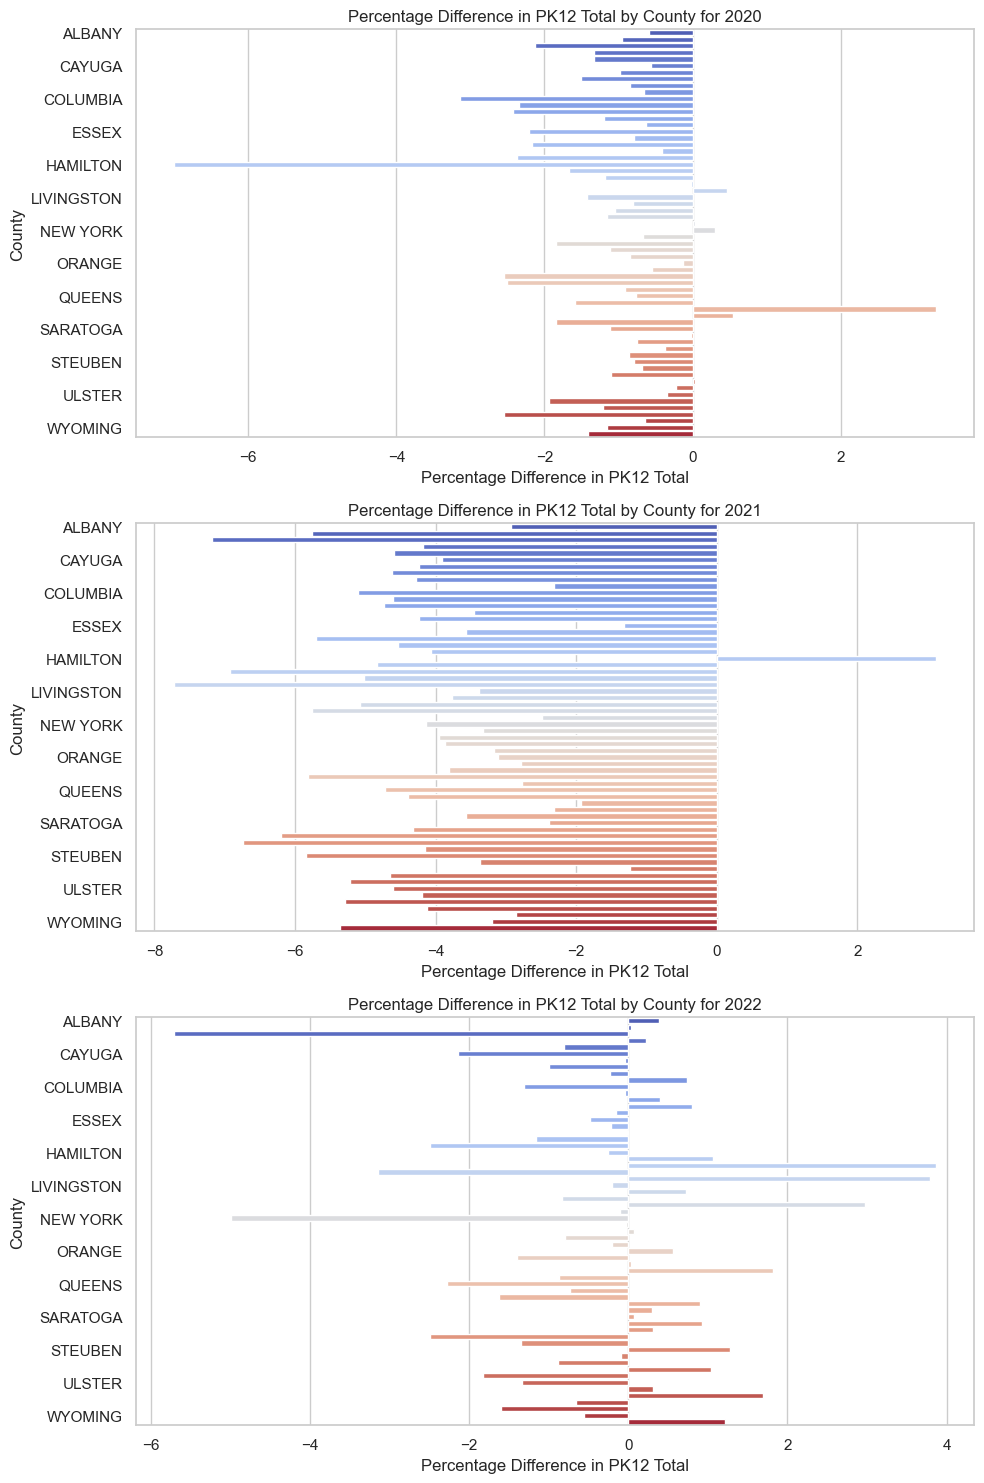

In [43]:
# To show every 5th label on the y-axis, we can adjust the set of labels to be displayed after plotting

# Create a figure with 3 subplots for the percentage differences
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Define a common function to set every 5th label
def set_every_fifth_label(ax):
    # Get all the current y-tick labels on the plot
    labels = ax.get_yticklabels()
    # Calculate which labels to keep (every 5th label)
    new_labels = [label if i % 5 == 0 else '' for i, label in enumerate(labels)]
    # Set the new list of labels on the plot
    ax.set_yticklabels(new_labels)

# Plot for 2020 with adjusted y-tick labels
sns.barplot(x='percent_diff_pk12_total', y='county', data=data_2020, ax=axes[0], palette='coolwarm')
axes[0].set_title('Percentage Difference in PK12 Total by County for 2020')
axes[0].set_xlabel('Percentage Difference in PK12 Total')
axes[0].set_ylabel('County')
set_every_fifth_label(axes[0])

# Plot for 2021 with adjusted y-tick labels
sns.barplot(x='percent_diff_pk12_total', y='county', data=data_2021, ax=axes[1], palette='coolwarm')
axes[1].set_title('Percentage Difference in PK12 Total by County for 2021')
axes[1].set_xlabel('Percentage Difference in PK12 Total')
axes[1].set_ylabel('County')
set_every_fifth_label(axes[1])

# Plot for 2022 with adjusted y-tick labels
sns.barplot(x='percent_diff_pk12_total', y='county', data=data_2022, ax=axes[2], palette='coolwarm')
axes[2].set_title('Percentage Difference in PK12 Total by County for 2022')
axes[2].set_xlabel('Percentage Difference in PK12 Total')
axes[2].set_ylabel('County')
set_every_fifth_label(axes[2])

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

### Merging the IRS and ACS datasets

In [64]:
# ensuring county is in small case
net_migration['county'] = net_migration['county'].str.lower()

In [65]:
# merging the IRS and ACS datasets
merged_irs_acs = pd.merge(net_migration, filtered_ACS_analysis, on='county', how='inner')

In [66]:
merged_irs_acs.head()

county state  year  n_inflows  agi_incomers  n_outflows   agi_leavers  \
0    albany    NY  2020      11450  42426.520000       11798   6651.179104   
1    albany    NY  2021      10942   8901.510204       11282   6984.348485   
2  allegany    NY  2020        817   2657.857143         754   2849.166667   
3  allegany    NY  2021        795   2906.714286         711   2897.500000   
4     bronx    NY  2020      37924  10059.186047       67282  10612.786585   

   net_flows          GEO_ID                  NAME_2019  ... DP05_0086E_2022  \
0       -348  0500000US36001    Albany County, New York  ...            3601   
1       -340  0500000US36001    Albany County, New York  ...            3601   
2         63  0500000US24001  Allegany County, Maryland  ...             202   
3         84  0500000US24001  Allegany County, Maryland  ...             202   
4     -29358  0500000US36005     Bronx County, New York  ...            9554   

  DP05_0087E_2022 DP05_0088E_2022 DP05_0089E_2022 DP05_0090E_2022  \
0           10156          147634          247318          118263   
1           10156          147634          247318          118263   
2            3131           32729           54749           28929   
3            3131           32729           54749           28929   
4           15444          557985          849259          383063   

  DP05_0091E_2022        GEO_ID.1                NAME_2019.1  \
0          129055  0500000US36001    Albany County, New York   
1          129055  0500000US36001    Albany County, New York   
2           25820  0500000US24001  Allegany County, Maryland   
3           25820  0500000US24001  Allegany County, Maryland   
4          466196  0500000US36005     Bronx County, New York   

                 NAME_2021.1                NAME_2022.1  
0    Albany County, New York    Albany County, New York  
1    Albany County, New York    Albany County, New York  
2  Allegany County, Maryland  Allegany County, Maryland  
3  Allegany County, Maryland  Allegany County, Maryland  
4     Bronx County, New York     Bronx County, New York  

[5 rows x 284 columns]

In [87]:
# plotting two variables from the merged dataset
merged_irs_acs_21 = merged_irs_acs[merged_irs_acs['year'] == '2021']
merged_irs_acs_21['DP05_0001E_2021'] = pd.to_numeric(merged_irs_acs_21['DP05_0001E_2021'], errors='coerce')
merged_irs_acs_21.head()

county state  year  n_inflows  agi_incomers  n_outflows   agi_leavers  \
1       albany    NY  2021      10942   8901.510204       11282   6984.348485   
3     allegany    NY  2021        795   2906.714286         711   2897.500000   
5        bronx    NY  2021      33903   9767.445652       71180  11540.416185   
7       broome    NY  2021       2847   4172.428571        2980   3064.060606   
9  cattaraugus    NY  2021       1492   5625.142857        1350   5113.000000   

   net_flows          GEO_ID                     NAME_2019  ...  \
1       -340  0500000US36001       Albany County, New York  ...   
3         84  0500000US24001     Allegany County, Maryland  ...   
5     -37277  0500000US36005        Bronx County, New York  ...   
7       -133  0500000US36007       Broome County, New York  ...   
9        142  0500000US36009  Cattaraugus County, New York  ...   

  DP05_0086E_2022 DP05_0087E_2022 DP05_0088E_2022 DP05_0089E_2022  \
1            3601           10156          147634          247318   
3             202            3131           32729           54749   
5            9554           15444          557985          849259   
7            3139            5425           93194          154963   
9            2152            1980           40356           60065   

  DP05_0090E_2022 DP05_0091E_2022        GEO_ID.1  \
1          118263          129055  0500000US36001   
3           28929           25820  0500000US24001   
5          383063          466196  0500000US36005   
7           74978           79985  0500000US36007   
9           30067           29998  0500000US36009   

                    NAME_2019.1                   NAME_2021.1  \
1       Albany County, New York       Albany County, New York   
3     Allegany County, Maryland     Allegany County, Maryland   
5        Bronx County, New York        Bronx County, New York   
7       Broome County, New York       Broome County, New York   
9  Cattaraugus County, New York  Cattaraugus County, New York   

                    NAME_2022.1  
1       Albany County, New York  
3     Allegany County, Maryland  
5        Bronx County, New York  
7       Broome County, New York  
9  Cattaraugus County, New York  

[5 rows x 284 columns]